# Facial Expression Recognition Project 
* We can see how we can use the same model that we have been using, Logistic Regression, only now pixels are going to be our inputs! 

# Goals of this project
### #1
* apply what we have learned to a new dataset
* However, all data is the same! It is really just more pracitce to build muscle memory!

### #2
* make our model class based, then we will create an object from the class
* this is designed to mimic the scikit learn interface 
* all SKLearn models work like this:
> * model = MyModel() -> create an instance of a model
  * model.fit(X, Y) -> fit to the data/train
  * model.predict(X) -> make future predictions
  * model.score(X, Y) -> gauge accuracy

* why do we want to do this? By having all of our code in 1 class, it makes it very reusable so that you don't have to write it again in the future! This is very powerful!

### #3
* Realize that all models have the same interface!

---
# Problem Description 
* this is a real world practical example of deep learning!
* we will compare and contrast each model in terms of accuracy, complexity, and training time
* this is not a computer understanding emotion, but just patterns of pictures!

## Dataset
* there is a free, preprocessed data set on kaggle that will allow us to work on this!
* The data is:
> * 48x48 grayscale images
  * Faces are centered and approximately the same size
  * 7 classes:
      * 0 = angry
      * 1 = disgust
      * 2 = fear
      * 3 = happy
      * 4 = sad
      * 5 = surprise
      * 6 = neutral
  * 3 column CSV: label, pixels (space separated), train/test 
  
## Logistic Regression
* because we have only worked with binary classification up until this point, we are just going to focus on class 0 and 1 
* However this is slightly problematic!
* There are 4953 samples of class 0, and 547 samples of class 1
* What does this mean? **Imbalanced Classes**!

## 2-class problem vs. 7-class problem
* When we switch to softmax (which we will in Deep Learning part 1), will the problem get easier or harder?
* 2 class: guess at random - expect 50% error
* 7 class: guess at random - expect 6/7 = 86% error
* K class: 1/K chance of being correct

## Structure of the Data
* Because these are images, they are naturally matrices!
* They are 48x48 pixels, which means we have 2304 dimensions
* We have no color - if there were color we would have a 3x48x48 = 6912 dimensions
* With logistic regression and basic neural networks, we will use a flat 2304 vector
    * this ignores spatial relationships and just considers each individual pixel intensity (in other words, it doesn't matter that pixel 49 is right next to pixel 1, we treat them all independently)
    * [ - row 1 -] (1-48)
    * [ - row 2 -] (49-96)
    * will become...
    * [- row 1 - - row 2 - - row 3 -...] (1-2304)
* if it was a convolutional neural network, we keep the original image shape 

## Normalize the data
* images have pixel intensities from 0-255 (8 bit integers have 2^8 = 256 different possible values)
* we want to normalize these to be from 0-1
* sometimes you can normalize by:
$$z = \frac{x - mean}{stddev}$$
* but since these a pixel values and they are strictly positive, we can just divide by the maximum
$$z = \frac{x}{maximum}$$
* the reason we want our values in such a small range is because this is where the function **sigmoid** is the most active! In the -1...+1 range 

## Challenges
* Deep learning doesn't really give you plug and chug black boxes, need to chose the right hyper parameters for it to work well!
### Hyperparameter 1 - Learning Rate
* if we chose something too high the cost is going to explode and become NaN
* If we chose something too low you will have a very slow convergence 

### Hyperparameter 2 - Correct Regularization 
* if we chose something too high, your weights will just want to go down to very small numbers without regards of cost
* if you set it too low, then it may not have any effect at all, and then the cost may still explode and become NaN

### Hyperparameter 2 - Epochs
* How many epochs should we use?
* if we stop too early it may be a steep slope, which means that we could have kept going
* if we stop too late, then that means that we kept going for much longer than we had to in order to solve the problem 

---
# The Class Imbalance Problem
* Recall that we only have 547 samples from class 1 and 4953 samples from class 0 (class 1 is the only underrpresented class)
* This shows up often in the medical field:
    * most of the population doesn't have the disease (99%)
    * only 1% has the disease
    * if the classifier predicts no every time, it is 99% accurate! But we still haven't learned ANYTHING
* Note, this description is somewhat flawed, since we don't actually train our classifier via accuracy or error rate 
* We use the cross-entropy!
* However, this still has the same problem, since the cross entropy wants to decrease the total cost
* So if 99% of the terms in the total cost are negative samples, the discriminating hyper plane is going to be pulled in that direction 
* So how do we fix this...?

# Solving Class Imbalance
* suppose we have 1000 samples from class 1, and 100 samples from class 2
## Method 1
* pick 100 samples from class 1 randomly, now we have 100 vs 100
## Method 2
* repeat class 2 10 times, now we have 1000 vs. 1000

## Comparison
* Both strategies have the same **expected** error rates
* however, as we know, variance matters too! 
* overall, method 2 has less variance because it has more data! 

## Other options
* we could also add Gaussian Noise (can't be too high, or will make image unrecognizable)
* Could also add invariant transformations (shift to left or right) 

# Other Accuracy Measures
* Confusion matrix!
* we want to maximize true positive and true negative, and minimize false positive and false negative 
* can look at Precision, Recall, Accuracy, F1-score

# ROC and AUC 
* can change threshold from 0.5 to any other value!

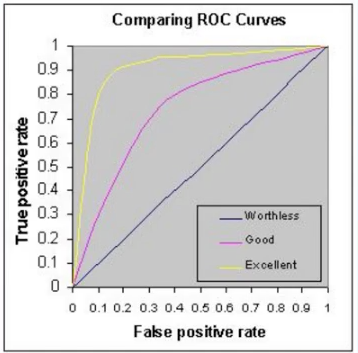

--- 
# Facial Expression Recognition in Code

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from util import getBinaryData, sigmoid, sigmoid_cost, error_rate

In [24]:
class LogisticModel(object):
    def __init__(self):
        pass
    
    def fit(self, X, Y, learning_rate=10e-7, reg=0, epochs=120000, show_fig=False):
        # shuffle X and Y
        X, Y = shuffle(X, Y)
        
        # split X and Y into training and testing sets
        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        X, Y = X[:-1000], Y[:-1000]
        
        # get shape of X
        N, D = X.shape
        
        # initialize weights
        self.W = np.random.randn(D) / np.sqrt(D)
        self.b = 0
        costs = []
        best_validation_error = 1
        for i in range(epochs): 
            pY = self.forward(X)
            
            # gradient descent step
            self.W -= learning_rate*(X.T.dot(pY - Y) + reg*self.W)
            self.b -= learning_rate*((pY - Y).sum() + reg*self.b)
            
            if i % 20 == 0:
                pYvalid = self.forward(Xvalid)
                c = sigmoid_cost(Yvalid, pYvalid)
                costs.append(c)
                e = error_rate(Yvalid, np.round(pYvalid))
                print("i:", i, "cost:", c, "error:", e)
                if e < best_validation_error:
                    best_validation_error = e
        print("best_validation_error:", best_validation_error)

        if show_fig:
            plt.plot(costs)
            plt.show()
            
    def forward(self, X):
        return sigmoid(X.dot(self.W) + self.b)
    
    def predict(self, X):
        pY = self.forward(X)
        return np.round(pY)
    
    def score(self, X, Y):
        prediction = self.predict(X)
        return 1 - error_rate(Y, prediction)

In [ ]:
def main():
    X, Y = getBinaryData()

    X0 = X[Y==0, :]
    X1 = X[Y==1, :]
    X1 = np.repeat(X1, 9, axis=0)
    X = np.vstack([X0, X1])
    Y = np.array([0]*len(X0) + [1]*len(X1))
    
    model = LogisticModel()
    model.fit(X, Y, show_fig=True)
    model.score(X, Y)

if __name__ == '__main__':
    main()

i: 0 cost: 689.64126493 error: 0.443
i: 20 cost: 679.462955895 error: 0.409
i: 40 cost: 671.917061696 error: 0.394
i: 60 cost: 665.858274675 error: 0.371
i: 80 cost: 660.821906266 error: 0.367
i: 100 cost: 656.539848253 error: 0.369
i: 120 cost: 652.836392612 error: 0.367
i: 140 cost: 649.588062081 error: 0.368
i: 160 cost: 646.704461539 error: 0.361
i: 180 cost: 644.11757852 error: 0.365
i: 200 cost: 641.775180004 error: 0.362
i: 220 cost: 639.636483014 error: 0.359
i: 240 cost: 637.669200427 error: 0.359
i: 260 cost: 635.847464966 error: 0.356
i: 280 cost: 634.150335579 error: 0.351
i: 300 cost: 632.560701394 error: 0.349
i: 320 cost: 631.064463762 error: 0.346
i: 340 cost: 629.649916867 error: 0.338
i: 360 cost: 628.307272743 error: 0.337
i: 380 cost: 627.028292997 error: 0.337
i: 400 cost: 625.806000465 error: 0.337
i: 420 cost: 624.634451505 error: 0.337
i: 440 cost: 623.508554758 error: 0.339
i: 460 cost: 622.423925868 error: 0.338
i: 480 cost: 621.376770271 error: 0.338
i: 500 c

i: 4060 cost: 549.286522984 error: 0.271
i: 4080 cost: 549.083153565 error: 0.27
i: 4100 cost: 548.880743466 error: 0.27
i: 4120 cost: 548.679284572 error: 0.27
i: 4140 cost: 548.478768863 error: 0.27
i: 4160 cost: 548.279188413 error: 0.27
i: 4180 cost: 548.080535386 error: 0.269
i: 4200 cost: 547.882802039 error: 0.269
i: 4220 cost: 547.685980715 error: 0.269
i: 4240 cost: 547.490063847 error: 0.269
i: 4260 cost: 547.295043953 error: 0.268
i: 4280 cost: 547.100913639 error: 0.268
i: 4300 cost: 546.90766559 error: 0.268
i: 4320 cost: 546.715292579 error: 0.267
i: 4340 cost: 546.523787456 error: 0.267
i: 4360 cost: 546.333143155 error: 0.267
i: 4380 cost: 546.143352686 error: 0.268
i: 4400 cost: 545.954409139 error: 0.268
i: 4420 cost: 545.766305681 error: 0.268
i: 4440 cost: 545.579035552 error: 0.268
i: 4460 cost: 545.392592071 error: 0.267
i: 4480 cost: 545.206968626 error: 0.267
i: 4500 cost: 545.022158682 error: 0.267
i: 4520 cost: 544.838155773 error: 0.267
i: 4540 cost: 544.6549

i: 8100 cost: 520.708682463 error: 0.259
i: 8120 cost: 520.607398989 error: 0.259
i: 8140 cost: 520.50637103 error: 0.259
i: 8160 cost: 520.405597282 error: 0.258
i: 8180 cost: 520.305076452 error: 0.258
i: 8200 cost: 520.204807255 error: 0.257
i: 8220 cost: 520.104788417 error: 0.256
i: 8240 cost: 520.005018672 error: 0.256
i: 8260 cost: 519.905496762 error: 0.256
i: 8280 cost: 519.80622144 error: 0.255
i: 8300 cost: 519.707191467 error: 0.255
i: 8320 cost: 519.608405612 error: 0.255
i: 8340 cost: 519.509862653 error: 0.255
i: 8360 cost: 519.411561378 error: 0.255
i: 8380 cost: 519.313500581 error: 0.255
i: 8400 cost: 519.215679067 error: 0.255
i: 8420 cost: 519.118095648 error: 0.255
i: 8440 cost: 519.020749145 error: 0.255
i: 8460 cost: 518.923638386 error: 0.255
i: 8480 cost: 518.826762209 error: 0.255
i: 8500 cost: 518.730119458 error: 0.255
i: 8520 cost: 518.633708986 error: 0.255
i: 8540 cost: 518.537529655 error: 0.255
i: 8560 cost: 518.441580334 error: 0.255
i: 8580 cost: 518.